In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# Set seed value
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load dataset 
data = yf.download('GOOG', start='2015-02-08', end='2025-02-08')
data = data[['Close']]
data.dropna(inplace=True)
# Keep a copy for plotting
data_plot = data.copy()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Check for missing values
print(data.isnull().sum())

Price  Ticker
Close  GOOG      0
dtype: int64


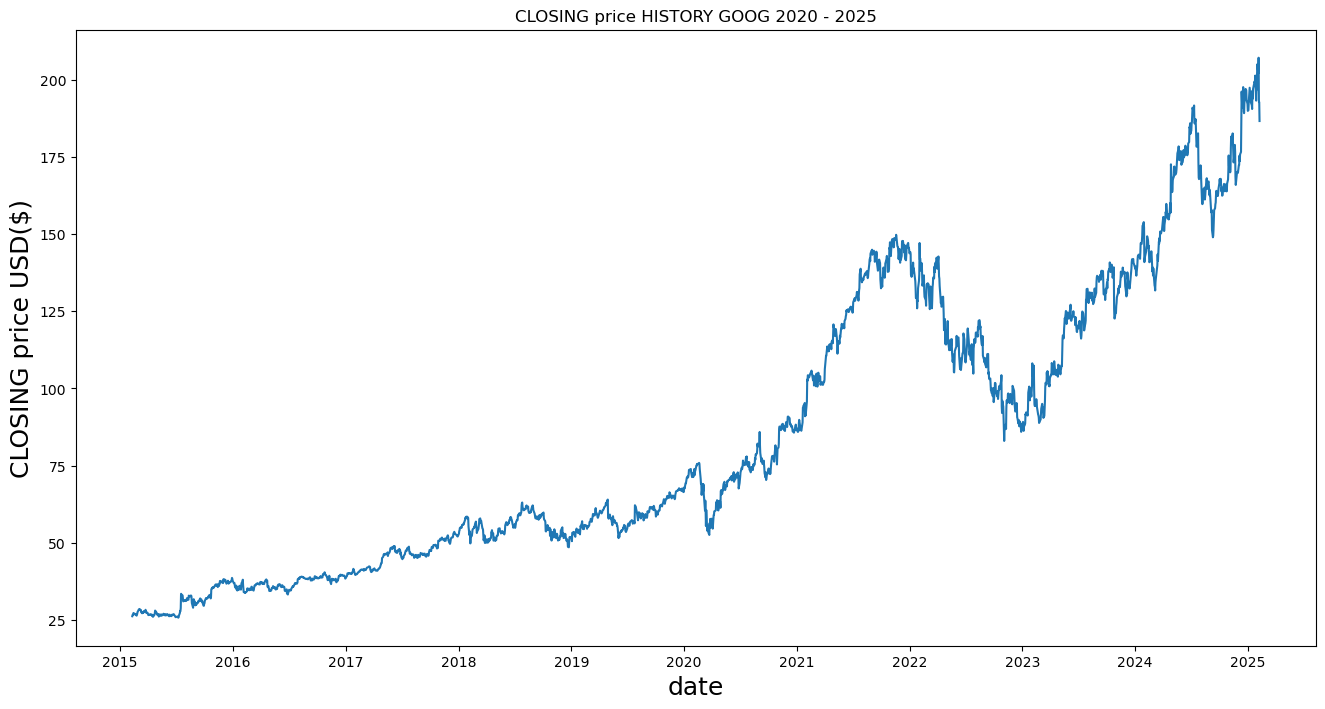

In [5]:
plt.figure(figsize=(16,8))
plt.title('CLOSING price HISTORY GOOG 2020 - 2025')
plt.plot(data['Close'])
plt.xlabel('date',fontsize=18)
plt.ylabel('CLOSING price USD($)',fontsize=18)
plt.show()

### DATA SPLITTING

In [7]:
data = data[['Close']].values
training_data_len = math.ceil(len(data) * 0.8)

In [8]:
train_data = data[:training_data_len]
test_data = data[training_data_len:]

### DATA SCALING

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

### SEQUENCES

In [12]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set time steps (lookback window)
time_steps = 30

# Create training sequences
X_train, y_train = create_sequences(scaled_train_data, time_steps)

# Create test sequences
# Combine last 30 points of training data with test data for proper sequencing
scaled_full_data = np.concatenate([scaled_train_data, scaled_test_data])
X_test, y_test = create_sequences(scaled_full_data[len(scaled_train_data)-time_steps:], time_steps)

### RESHAPE

In [14]:
# Reshape 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1983, 30, 1)
Test data shape: (503, 30, 1)


## LSTM MODEL

In [16]:
lstm_model = Sequential()

# First LSTM layer with dropout
lstm_model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.1))

# Second LSTM layer with dropout
lstm_model.add(LSTM(32, return_sequences=False))
lstm_model.add(Dropout(0.1))

# Output layer
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
lstm_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0012
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0124
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0091
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0082
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0192
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0301
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0176
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013  
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.5583e-04
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.2895e-04
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.9055e-04
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - los

### LSTM PREDICTIONS

In [19]:
# Predict
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
r2 = r2_score(y_test_actual, lstm_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
RMSE: 10.5861
R² Score: 0.8581


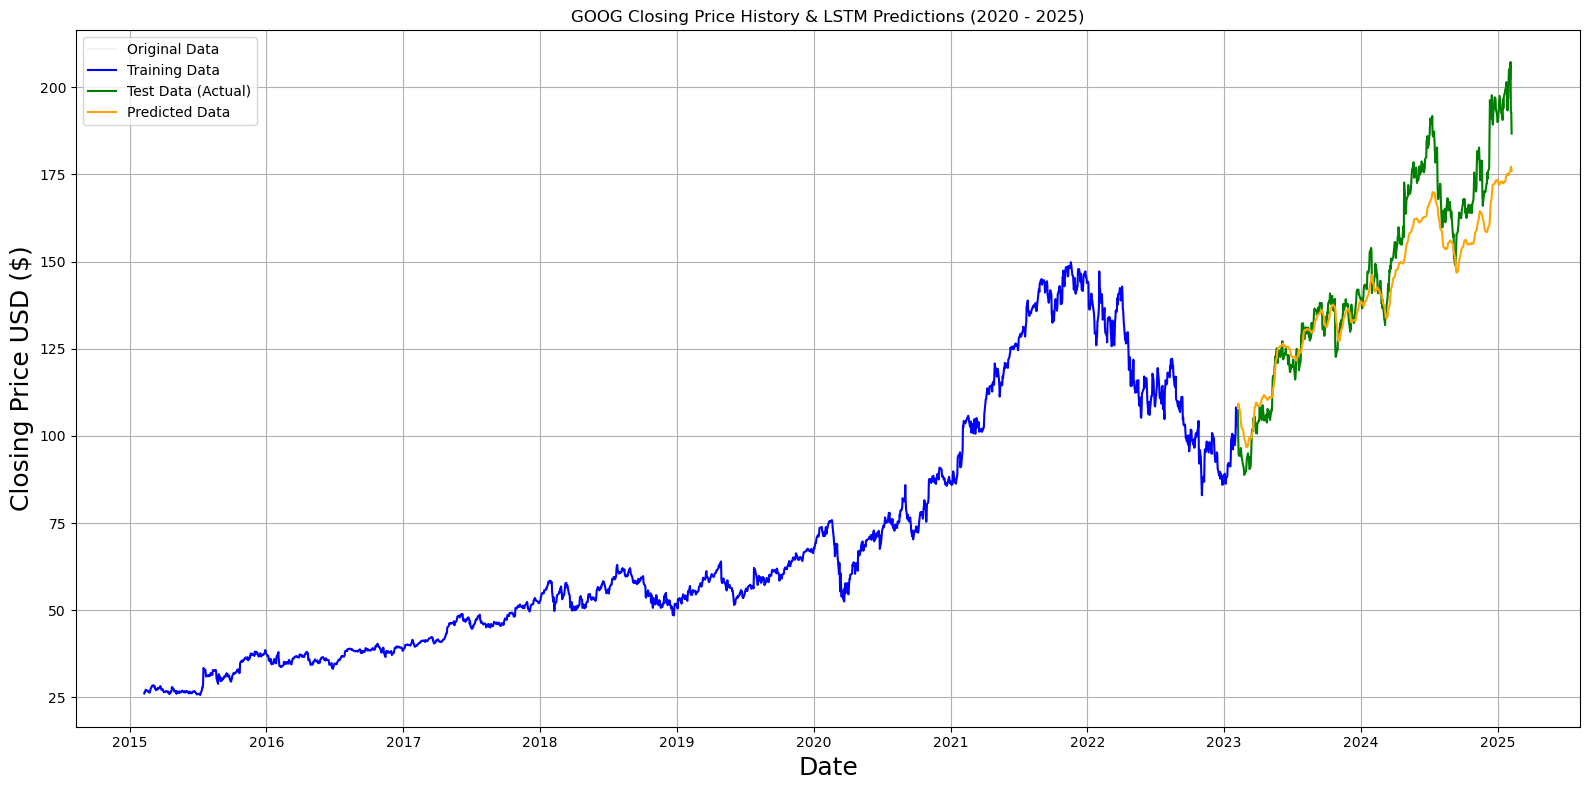

In [20]:
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & LSTM Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, lstm_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## GRU MODEL

In [22]:
gru_model = Sequential()

# First GRU layer with dropout
gru_model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.1))

# Second GRU layer with dropout
gru_model.add(GRU(32, return_sequences=False))
gru_model.add(Dropout(0.1))

# Output layer
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
gru_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7.7995e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0058
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0081
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0099
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0068
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0104
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0149
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0160
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0231
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0275
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0282


### GRU PREDICTIONS

In [25]:
# Predict
gru_predictions = gru_model.predict(X_test)

# Inverse transform
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, gru_predictions))
r2 = r2_score(y_test_actual, gru_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")    

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RMSE: 8.0181
R² Score: 0.9186


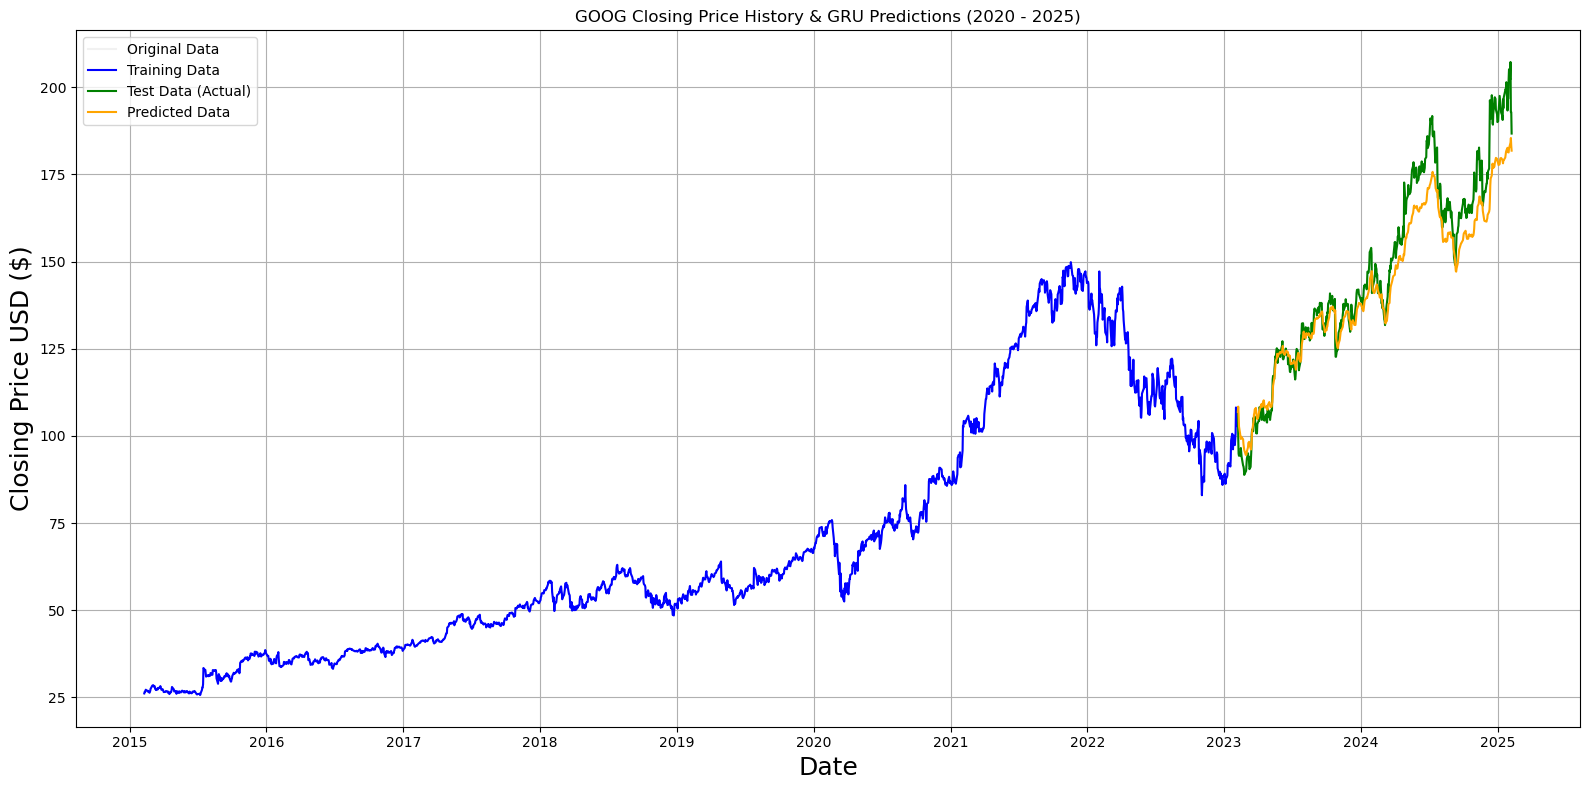

In [26]:
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & GRU Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, gru_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM-GRU MODEL

In [28]:
lstm_gru_model = Sequential()

# First LSTM layer with dropout
lstm_gru_model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_gru_model.add(Dropout(0.1))

# Second GRU layer with dropout
lstm_gru_model.add(GRU(32, return_sequences=False))
lstm_gru_model.add(Dropout(0.1))

# Output layer
lstm_gru_model.add(Dense(1))

lstm_gru_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_gru_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,721 (41.88 KB)

 Trainable params: 10,721 (41.88 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
lstm_gru_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0010    
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0100
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0124
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0087
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0114
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0209
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0324
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0352
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0032
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.3017e-04
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3510e-04
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.0014e-04
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.0526e-04
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

### LSTM-GRU PREDICTIONS

In [31]:
# Predict
lstm_gru_predictions = lstm_gru_model.predict(X_test)

# Inverse transform
lstm_gru_predictions = scaler.inverse_transform(lstm_gru_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_gru_predictions))
r2 = r2_score(y_test_actual, lstm_gru_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")   

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RMSE: 9.3389
R² Score: 0.8896


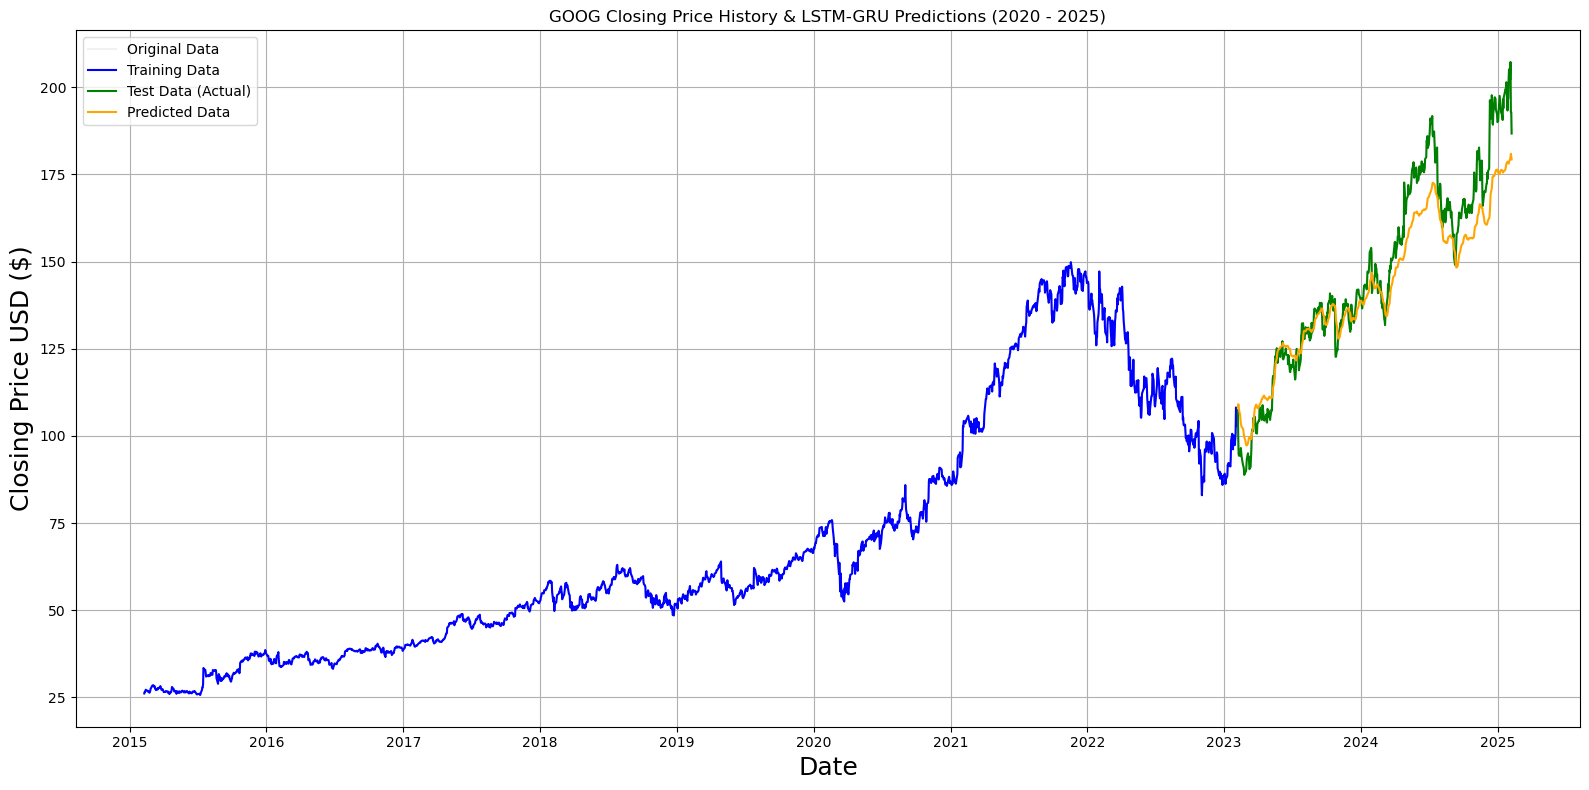

In [32]:
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & LSTM-GRU Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, lstm_gru_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### GRU-LSTM MODEL

In [34]:
gru_lstm_model = Sequential()

# First GRU layer with dropout
gru_lstm_model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_lstm_model.add(Dropout(0.1))

# Second LSTM layer with dropout
gru_lstm_model.add(LSTM(32, return_sequences=False))
gru_lstm_model.add(Dropout(0.1))

# Output layer
gru_lstm_model.add(Dense(1))

gru_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

gru_lstm_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 30, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,713 (45.75 KB)

 Trainable params: 11,713 (45.75 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
gru_lstm_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 9.9014e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0045
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0093
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0093
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0109
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0198
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0347
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0119
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0033
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.0766e-04
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.4070e-04
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8322e-04
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - l

### GRU-LSTM PREDICTIONS

In [37]:
# Predict
gru_lstm_predictions = gru_lstm_model.predict(X_test)

# Inverse transform
gru_lstm_predictions = scaler.inverse_transform(gru_lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, gru_lstm_predictions))
r2 = r2_score(y_test_actual, gru_lstm_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")  

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
RMSE: 8.6203
R² Score: 0.9059


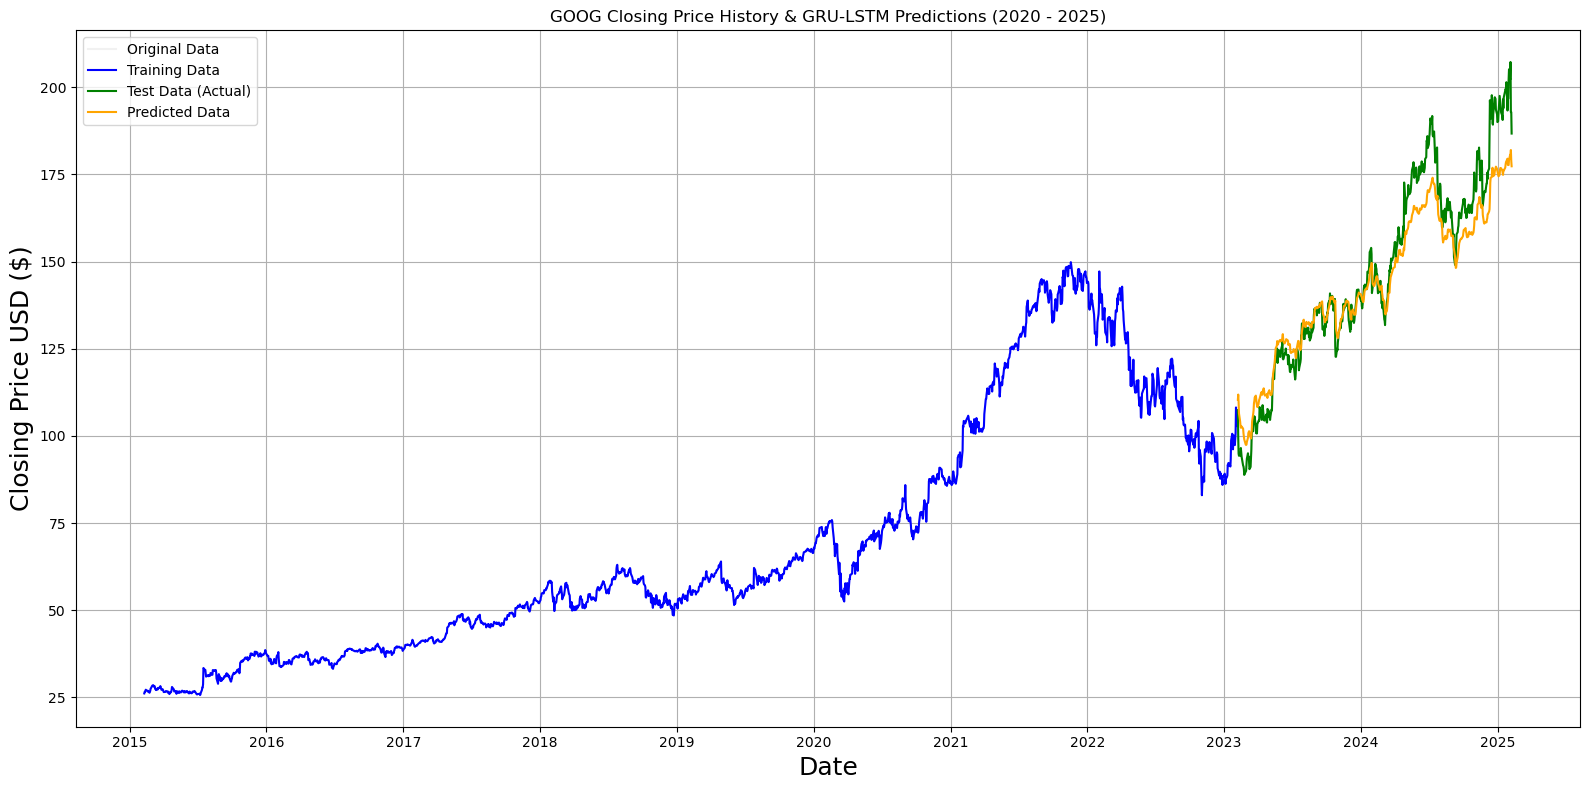

In [38]:
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & GRU-LSTM Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, gru_lstm_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

### LSTM TUNING

In [41]:
# ---------------------------
# Define LSTM model builder
# ---------------------------
def build_lstm_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}


n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_lstm_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:28<23:00, 28.17s/it]

RMSE: 16.4727, R²: 0.6564

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [00:50<19:36, 24.50s/it]

RMSE: 25.1934, R²: 0.1962

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:54<33:32, 42.82s/it]

RMSE: 7.1704, R²: 0.9349

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:25<29:19, 38.25s/it]

RMSE: 33.1707, R²: -0.3934

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [02:53<25:49, 34.42s/it]

RMSE: 22.1358, R²: 0.3795

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:28<25:19, 34.54s/it]

RMSE: 51.7128, R²: -2.3865

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:07<25:43, 35.90s/it]

RMSE: 5.7374, R²: 0.9583

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [04:58<28:31, 40.75s/it]

RMSE: 17.6314, R²: 0.6063

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [05:32<26:22, 38.61s/it]

RMSE: 6.7557, R²: 0.9422

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [05:55<22:34, 33.85s/it]

RMSE: 16.1021, R²: 0.6717

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [06:26<21:32, 33.13s/it]

RMSE: 33.0997, R²: -0.3874

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [06:52<19:38, 31.01s/it]

RMSE: 31.9040, R²: -0.2890

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [07:18<18:06, 29.36s/it]

RMSE: 51.6397, R²: -2.3769

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [07:56<19:06, 31.85s/it]

RMSE: 13.8798, R²: 0.7560

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [08:18<16:52, 28.94s/it]

RMSE: 28.0884, R²: 0.0009

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [08:58<18:15, 32.23s/it]

RMSE: 7.0764, R²: 0.9366

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [09:24<16:46, 30.50s/it]

RMSE: 48.9327, R²: -2.0321

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [09:55<16:22, 30.71s/it]

RMSE: 50.0541, R²: -2.1727

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [11:33<26:14, 50.78s/it]

RMSE: 5.0805, R²: 0.9673

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [12:32<26:40, 53.34s/it]

RMSE: 5.0226, R²: 0.9681

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [13:13<23:55, 49.50s/it]

RMSE: 6.5033, R²: 0.9464

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [13:40<19:58, 42.80s/it]

RMSE: 62.5591, R²: -3.9560

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [14:22<19:07, 42.51s/it]

RMSE: 31.7491, R²: -0.2765

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [15:14<19:40, 45.41s/it]

RMSE: 41.6046, R²: -1.1920

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [16:16<21:01, 50.46s/it]

RMSE: 6.1441, R²: 0.9522

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [16:43<17:19, 43.32s/it]

RMSE: 7.9504, R²: 0.9200

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [18:00<20:33, 53.62s/it]

RMSE: 6.2294, R²: 0.9509

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [18:58<20:05, 54.81s/it]

RMSE: 51.2847, R²: -2.3306

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [19:37<17:28, 49.91s/it]

RMSE: 4.8346, R²: 0.9704

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [19:57<13:42, 41.10s/it]

RMSE: 13.0450, R²: 0.7845

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [20:31<12:18, 38.85s/it]

RMSE: 41.1836, R²: -1.1478

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [21:03<11:04, 36.92s/it]

RMSE: 10.8148, R²: 0.8519

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [21:33<09:50, 34.75s/it]

RMSE: 21.6971, R²: 0.4039

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [22:26<10:46, 40.43s/it]

RMSE: 3.6410, R²: 0.9832

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [22:55<09:13, 36.88s/it]

RMSE: 10.7064, R²: 0.8548

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [24:19<11:53, 50.95s/it]

RMSE: 5.3659, R²: 0.9635

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [25:06<10:46, 49.72s/it]

RMSE: 46.7386, R²: -1.7663

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [27:06<14:09, 70.78s/it]

RMSE: 4.2359, R²: 0.9773

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [28:08<12:31, 68.32s/it]

RMSE: 7.6682, R²: 0.9255

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [28:31<09:06, 54.63s/it]

RMSE: 23.0950, R²: 0.3246

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [29:23<08:05, 53.94s/it]

RMSE: 8.0959, R²: 0.9170

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [29:57<06:22, 47.84s/it]

RMSE: 31.5697, R²: -0.2621

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [30:18<04:37, 39.70s/it]

RMSE: 16.0427, R²: 0.6741

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [30:39<03:24, 34.15s/it]

RMSE: 27.4377, R²: 0.0467

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [31:13<02:51, 34.33s/it]

RMSE: 26.9681, R²: 0.0790

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [31:56<02:27, 36.90s/it]

RMSE: 5.0568, R²: 0.9676

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [32:51<02:06, 42.30s/it]

RMSE: 17.8885, R²: 0.5948

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [33:37<01:26, 43.42s/it]

RMSE: 8.0605, R²: 0.9177

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [34:28<00:45, 45.48s/it]

RMSE: 19.6146, R²: 0.5128

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [35:34<00:00, 42.69s/it]

RMSE: 16.8504, R²: 0.6404

Best Parameters:
validation_split                                                  0.2
units                                                              32
lr                                                               0.01
epochs                                                             50
dropout                                                           0.2
batch_size                                                         32
rmse                                                         3.641028
r2                                                           0.983212
val_loss                                                     0.001175
train_loss                                                   0.011458
preds               [104.998764, 105.98071, 102.625786, 97.298325,...
y_true              [107.40158081054688, 99.40910339355469, 94.895...
Name: 33, dtype: object
Best RMSE: 3.6410
Best R²: 0.9832


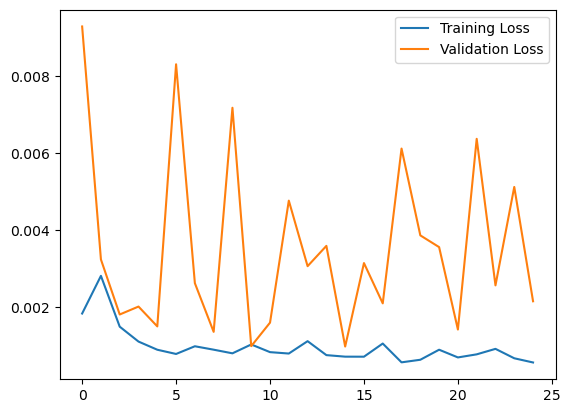

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

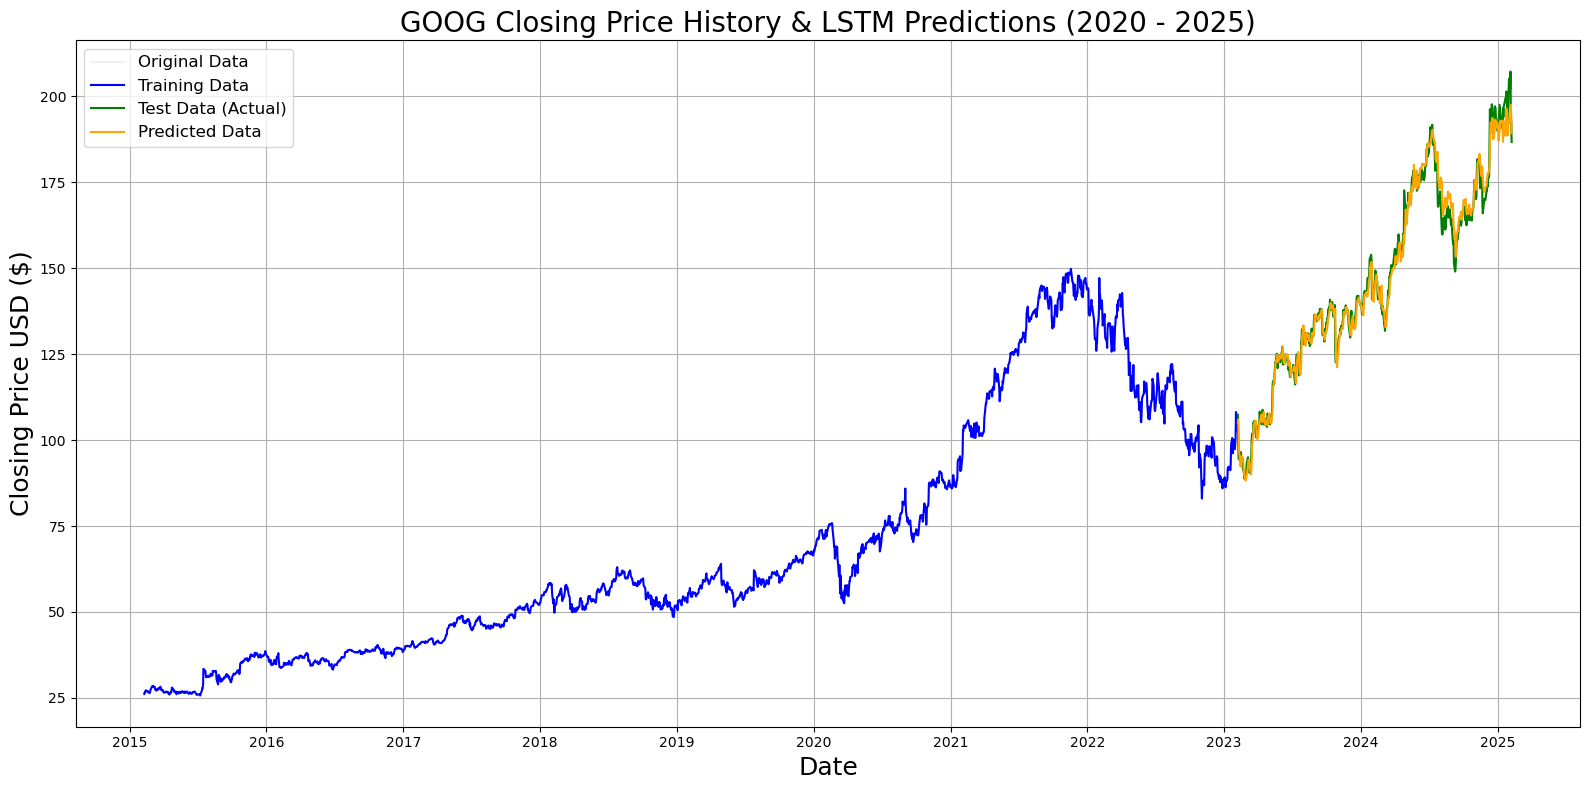

In [43]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & LSTM Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### GRU TUNING

In [45]:
# ---------------------------
# Define GRU model builder
# ---------------------------
def build_gru_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}


n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_gru_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:36<29:34, 36.21s/it]

RMSE: 4.9741, R²: 0.9687

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [01:07<26:51, 33.57s/it]

RMSE: 5.4615, R²: 0.9622

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:56<31:47, 40.59s/it]

RMSE: 4.5246, R²: 0.9741

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:56<36:45, 47.95s/it]

RMSE: 28.1607, R²: -0.0042

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [03:33<33:07, 44.16s/it]

RMSE: 4.5870, R²: 0.9734

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [04:01<28:23, 38.71s/it]

RMSE: 28.7425, R²: -0.0462

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:24<24:05, 33.61s/it]

RMSE: 6.3301, R²: 0.9493

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [05:04<24:58, 35.68s/it]

RMSE: 13.7011, R²: 0.7623

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [05:45<25:26, 37.23s/it]

RMSE: 6.5884, R²: 0.9450

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [06:19<24:06, 36.16s/it]

RMSE: 6.1187, R²: 0.9526

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [06:51<22:37, 34.81s/it]

RMSE: 13.4235, R²: 0.7718

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [07:21<21:17, 33.62s/it]

RMSE: 21.1645, R²: 0.4328

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [07:45<18:47, 30.46s/it]

RMSE: 31.2307, R²: -0.2351

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [08:42<23:12, 38.67s/it]

RMSE: 3.7981, R²: 0.9817

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [09:30<24:05, 41.31s/it]

RMSE: 45.0517, R²: -1.5702

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [09:55<20:41, 36.51s/it]

RMSE: 5.1137, R²: 0.9669

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [10:15<17:22, 31.60s/it]

RMSE: 17.6526, R²: 0.6054

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [10:50<17:22, 32.56s/it]

RMSE: 27.5521, R²: 0.0387

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [11:42<19:51, 38.44s/it]

RMSE: 3.6335, R²: 0.9833

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [12:29<20:32, 41.08s/it]

RMSE: 4.5725, R²: 0.9735

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [13:03<18:48, 38.92s/it]

RMSE: 4.3703, R²: 0.9758

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [13:27<16:00, 34.31s/it]

RMSE: 16.4459, R²: 0.6575

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [14:28<19:05, 42.42s/it]

RMSE: 39.5814, R²: -0.9840

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [15:09<18:13, 42.06s/it]

RMSE: 23.8331, R²: 0.2807

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [16:02<18:47, 45.09s/it]

RMSE: 15.9695, R²: 0.6771

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [16:30<16:00, 40.03s/it]

RMSE: 4.0859, R²: 0.9789

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [17:15<15:54, 41.52s/it]

RMSE: 3.7463, R²: 0.9822

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [18:18<17:39, 48.15s/it]

RMSE: 46.8834, R²: -1.7835

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [19:25<18:44, 53.55s/it]

RMSE: 4.9634, R²: 0.9688

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [19:56<15:36, 46.82s/it]

RMSE: 13.0261, R²: 0.7851

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [20:36<14:10, 44.78s/it]

RMSE: 34.2939, R²: -0.4893

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [21:25<13:52, 46.24s/it]

RMSE: 8.5416, R²: 0.9076

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [22:03<12:21, 43.62s/it]

RMSE: 7.7428, R²: 0.9241

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [22:31<10:21, 38.82s/it]

RMSE: 10.8522, R²: 0.8509

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [23:02<09:07, 36.49s/it]

RMSE: 5.6047, R²: 0.9602

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [23:44<08:54, 38.17s/it]

RMSE: 4.0546, R²: 0.9792

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [24:21<08:12, 37.89s/it]

RMSE: 13.7310, R²: 0.7612

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [25:21<08:53, 44.49s/it]

RMSE: 26.2777, R²: 0.1256

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [26:29<09:28, 51.66s/it]

RMSE: 4.4472, R²: 0.9750

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [26:59<07:30, 45.01s/it]

RMSE: 20.5802, R²: 0.4637

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [27:29<06:04, 40.51s/it]

RMSE: 19.3842, R²: 0.5242

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [28:05<05:12, 39.10s/it]

RMSE: 35.3091, R²: -0.5788

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [28:29<04:03, 34.79s/it]

RMSE: 4.1366, R²: 0.9783

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [28:59<03:19, 33.30s/it]

RMSE: 8.2440, R²: 0.9139

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [29:43<03:01, 36.38s/it]

RMSE: 17.8052, R²: 0.5985

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [30:16<02:22, 35.60s/it]

RMSE: 4.0676, R²: 0.9790

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [30:50<01:44, 34.95s/it]

RMSE: 7.9419, R²: 0.9201

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [31:19<01:06, 33.35s/it]

RMSE: 3.9350, R²: 0.9804

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [32:51<00:50, 50.92s/it]

RMSE: 29.6004, R²: -0.1095

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [33:53<00:00, 40.67s/it]

RMSE: 7.5998, R²: 0.9269

Best Parameters:
validation_split                                                  0.2
units                                                              32
lr                                                              0.001
epochs                                                             50
dropout                                                           0.1
batch_size                                                         16
rmse                                                         3.633454
r2                                                           0.983282
val_loss                                                     0.000741
train_loss                                                    0.00038
preds               [103.57653, 104.75564, 103.40459, 100.504845, ...
y_true              [107.40158081054688, 99.40910339355469, 94.895...
Name: 18, dtype: object
Best RMSE: 3.6335
Best R²: 0.9833


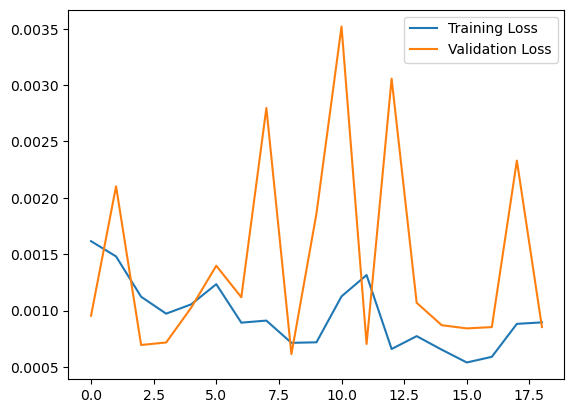

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

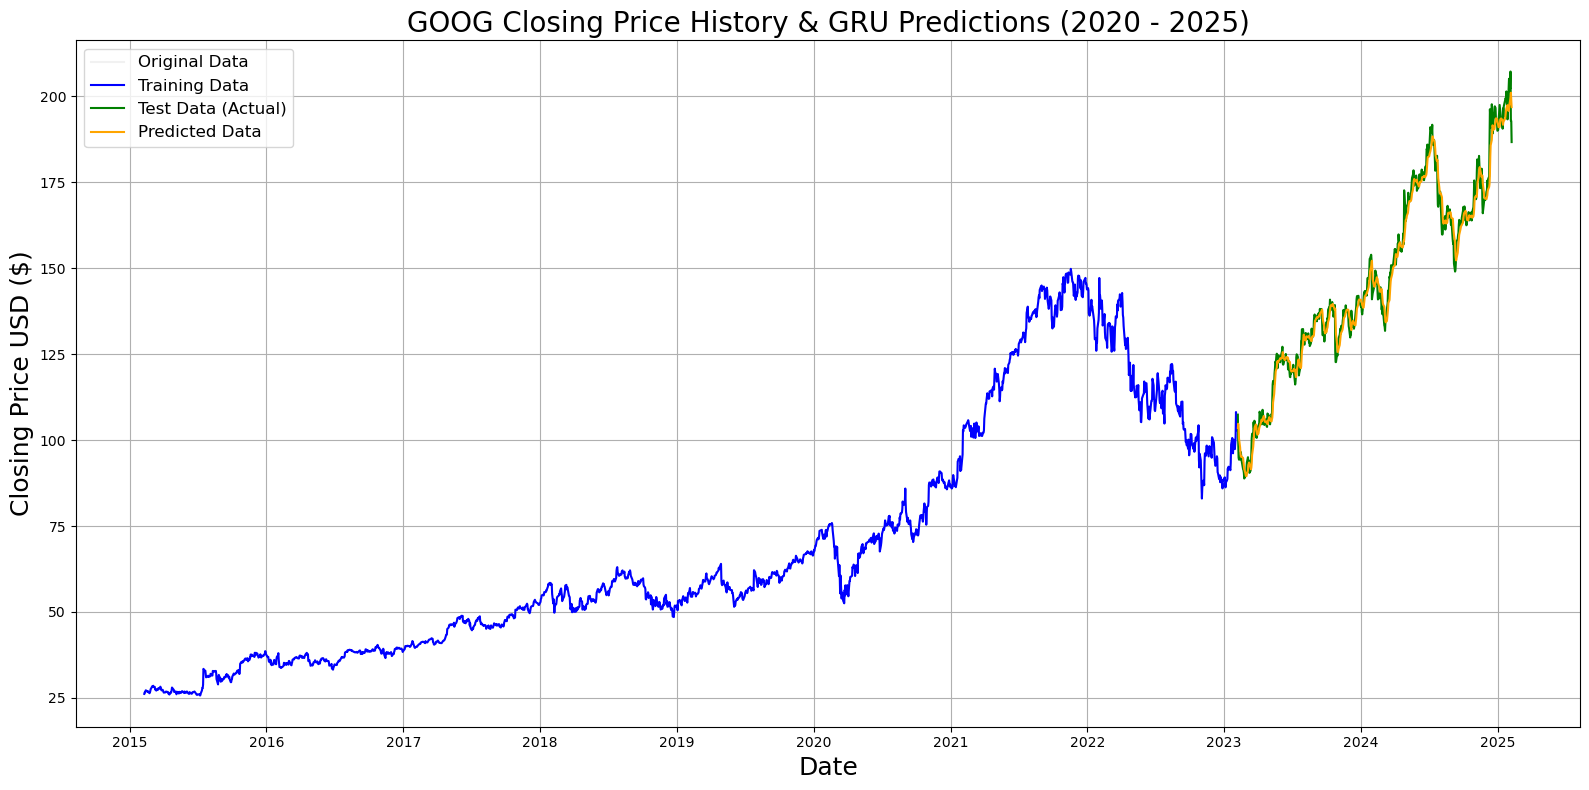

In [47]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & GRU Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### HYBRID LSTM-GRU

In [49]:
# ---------------------------
# Define LSTM-GRU model builder
# ---------------------------
def build_lstm_gru_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_lstm_gru_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:32<26:41, 32.69s/it]

RMSE: 15.5530, R²: 0.6937

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [00:59<23:13, 29.03s/it]

RMSE: 17.5188, R²: 0.6114

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:39<26:41, 34.07s/it]

RMSE: 7.7567, R²: 0.9238

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:16<27:06, 35.35s/it]

RMSE: 30.4957, R²: -0.1777

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [02:41<23:50, 31.78s/it]

RMSE: 21.5955, R²: 0.4094

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:25<26:17, 35.86s/it]

RMSE: 45.1852, R²: -1.5855

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:04<26:21, 36.79s/it]

RMSE: 5.7813, R²: 0.9577

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [04:32<23:43, 33.90s/it]

RMSE: 18.7979, R²: 0.5525

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [04:55<20:55, 30.61s/it]

RMSE: 6.9841, R²: 0.9382

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [05:19<18:56, 28.42s/it]

RMSE: 19.0458, R²: 0.5406

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [05:48<18:44, 28.84s/it]

RMSE: 41.2403, R²: -1.1537

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [06:15<17:48, 28.11s/it]

RMSE: 32.5920, R²: -0.3452

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [07:00<20:30, 33.25s/it]

RMSE: 12.0298, R²: 0.8167

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [07:50<22:59, 38.32s/it]

RMSE: 5.4357, R²: 0.9626

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [08:38<24:03, 41.24s/it]

RMSE: 21.8416, R²: 0.3959

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [09:03<20:39, 36.44s/it]

RMSE: 5.2609, R²: 0.9650

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [09:27<17:53, 32.53s/it]

RMSE: 36.5944, R²: -0.6958

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [10:09<18:54, 35.44s/it]

RMSE: 43.4348, R²: -1.3891

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [10:58<20:29, 39.65s/it]

RMSE: 6.1787, R²: 0.9517

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [11:56<22:30, 45.01s/it]

RMSE: 8.2355, R²: 0.9141

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [12:20<18:42, 38.70s/it]

RMSE: 6.4222, R²: 0.9478

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [12:48<16:37, 35.63s/it]

RMSE: 45.9459, R²: -1.6733

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [13:48<19:15, 42.79s/it]

RMSE: 38.5286, R²: -0.8798

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [15:00<22:18, 51.49s/it]

RMSE: 42.8463, R²: -1.3247

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [15:38<19:46, 47.47s/it]

RMSE: 26.9124, R²: 0.0828

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [16:24<18:54, 47.28s/it]

RMSE: 5.2064, R²: 0.9657

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [17:27<19:50, 51.75s/it]

RMSE: 5.4236, R²: 0.9628

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [18:06<17:37, 48.08s/it]

RMSE: 42.8956, R²: -1.3301

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [19:11<18:35, 53.13s/it]

RMSE: 4.7242, R²: 0.9717

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [19:32<14:26, 43.35s/it]

RMSE: 11.9181, R²: 0.8201

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [20:46<16:40, 52.67s/it]

RMSE: 43.7377, R²: -1.4225

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [21:36<15:32, 51.80s/it]

RMSE: 14.4744, R²: 0.7347

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [22:01<12:23, 43.72s/it]

RMSE: 5.6133, R²: 0.9601

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [22:45<11:41, 43.84s/it]

RMSE: 13.0599, R²: 0.7840

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [23:09<09:28, 37.90s/it]

RMSE: 8.2426, R²: 0.9140

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [23:54<09:21, 40.12s/it]

RMSE: 7.3162, R²: 0.9322

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [24:39<08:58, 41.45s/it]

RMSE: 30.3060, R²: -0.1631

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [25:14<07:56, 39.71s/it]

RMSE: 25.3398, R²: 0.1869

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [26:18<08:35, 46.89s/it]

RMSE: 4.7726, R²: 0.9712

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [27:26<08:51, 53.19s/it]

RMSE: 8.9657, R²: 0.8982

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [27:52<06:44, 44.97s/it]

RMSE: 25.9122, R²: 0.1497

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [28:36<05:57, 44.63s/it]

RMSE: 44.0002, R²: -1.4517

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [28:58<04:26, 38.06s/it]

RMSE: 14.1956, R²: 0.7448

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [29:37<03:48, 38.16s/it]

RMSE: 25.9714, R²: 0.1458

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [30:16<03:11, 38.38s/it]

RMSE: 25.3463, R²: 0.1865

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [31:02<02:43, 40.94s/it]

RMSE: 5.0509, R²: 0.9677

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [31:35<01:55, 38.51s/it]

RMSE: 4.8075, R²: 0.9707

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [32:11<01:15, 37.67s/it]

RMSE: 7.5990, R²: 0.9269

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [32:53<00:38, 38.98s/it]

RMSE: 33.2676, R²: -0.4015

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [35:24<00:00, 42.50s/it]

RMSE: 11.1183, R²: 0.8435

Best Parameters:
validation_split                                                  0.2
units                                                              50
lr                                                              0.001
epochs                                                             50
dropout                                                           0.2
batch_size                                                         16
rmse                                                         4.724244
r2                                                           0.971737
val_loss                                                     0.002138
train_loss                                                   0.002981
preds               [103.15441, 104.2048, 104.16091, 102.974464, 1...
y_true              [107.40158081054688, 99.40910339355469, 94.895...
Name: 28, dtype: object
Best RMSE: 4.7242
Best R²: 0.9717


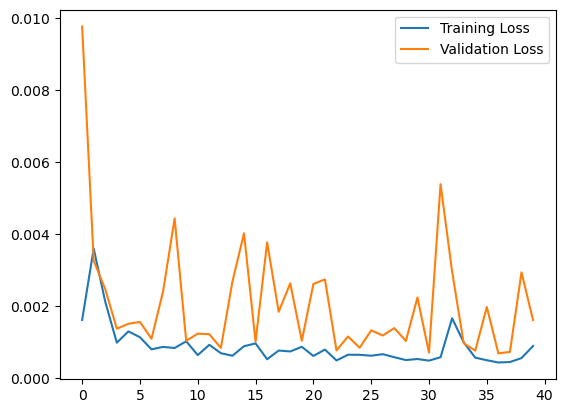

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

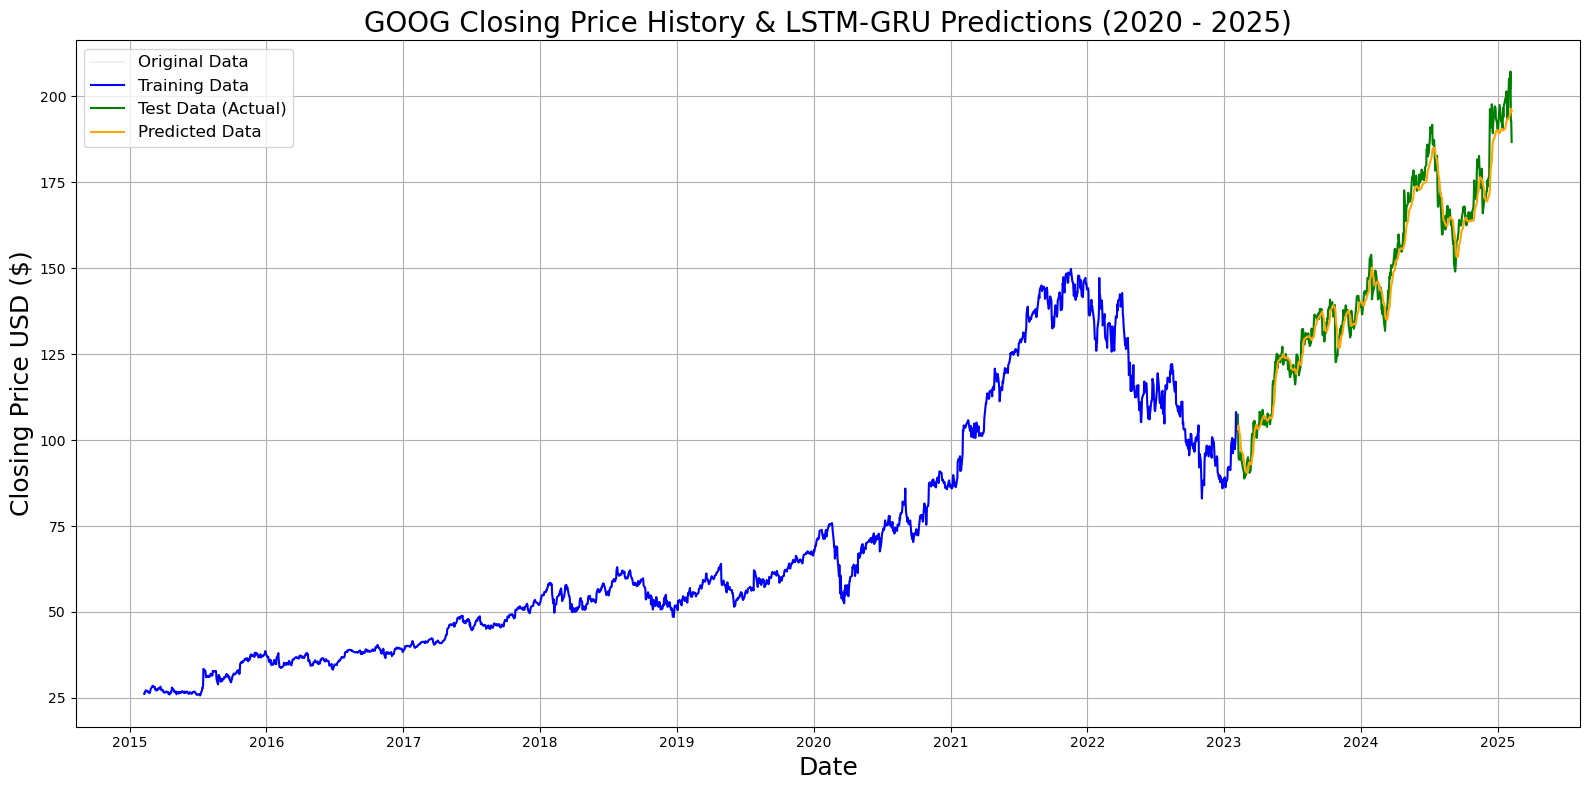

In [51]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & LSTM-GRU Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### HYBRID GRU-LSTM

In [53]:
# ---------------------------
# Define GRU-LSTM model builder
# ---------------------------
def build_gru_lstm_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_gru_lstm_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:30<24:52, 30.45s/it]

RMSE: 16.6739, R²: 0.6479

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [00:55<21:35, 26.99s/it]

RMSE: 16.8068, R²: 0.6423

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:47<30:09, 38.50s/it]

RMSE: 3.5999, R²: 0.9836

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:23<28:57, 37.78s/it]

RMSE: 29.5965, R²: -0.1093

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [02:46<24:21, 32.48s/it]

RMSE: 20.7471, R²: 0.4549

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:13<22:18, 30.41s/it]

RMSE: 27.1399, R²: 0.0672

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [03:53<24:04, 33.60s/it]

RMSE: 3.7910, R²: 0.9818

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [04:30<24:12, 34.58s/it]

RMSE: 15.9918, R²: 0.6762

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [04:57<21:58, 32.15s/it]

RMSE: 7.6780, R²: 0.9253

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [05:26<20:47, 31.19s/it]

RMSE: 20.2777, R²: 0.4793

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [05:51<19:11, 29.54s/it]

RMSE: 23.7970, R²: 0.2829

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [06:18<18:08, 28.66s/it]

RMSE: 20.5523, R²: 0.4651

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [06:42<16:50, 27.31s/it]

RMSE: 27.6310, R²: 0.0332

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [07:40<22:00, 36.67s/it]

RMSE: 9.4326, R²: 0.8873

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [08:18<21:28, 36.81s/it]

RMSE: 50.7185, R²: -2.2575

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [08:49<19:51, 35.03s/it]

RMSE: 9.3013, R²: 0.8904

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [09:11<17:06, 31.11s/it]

RMSE: 18.6678, R²: 0.5587

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [09:38<15:57, 29.92s/it]

RMSE: 27.9284, R²: 0.0123

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [10:33<19:22, 37.50s/it]

RMSE: 4.3950, R²: 0.9755

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [11:43<23:34, 47.16s/it]

RMSE: 3.3730, R²: 0.9856

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [12:24<21:55, 45.35s/it]

RMSE: 4.1488, R²: 0.9782

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [13:04<20:26, 43.80s/it]

RMSE: 22.7851, R²: 0.3426

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [14:08<22:26, 49.88s/it]

RMSE: 50.7477, R²: -2.2612

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [15:01<22:01, 50.85s/it]

RMSE: 42.1423, R²: -1.2490

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [16:11<23:32, 56.49s/it]

RMSE: 37.7702, R²: -0.8065

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [17:05<22:21, 55.89s/it]

RMSE: 6.7024, R²: 0.9431

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [17:54<20:39, 53.90s/it]

RMSE: 5.2337, R²: 0.9653

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [18:47<19:37, 53.52s/it]

RMSE: 51.1526, R²: -2.3135

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [21:06<27:44, 79.28s/it]

RMSE: 5.8852, R²: 0.9561

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [21:38<21:38, 64.94s/it]

RMSE: 11.2093, R²: 0.8409

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [22:34<19:44, 62.33s/it]

RMSE: 52.8317, R²: -2.5346

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [23:08<16:07, 53.74s/it]

RMSE: 11.3127, R²: 0.8379

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [23:36<13:04, 46.13s/it]

RMSE: 19.4390, R²: 0.5215

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [24:16<11:45, 44.09s/it]

RMSE: 12.7218, R²: 0.7951

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [24:45<09:57, 39.84s/it]

RMSE: 6.7159, R²: 0.9429

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [25:48<10:51, 46.56s/it]

RMSE: 3.9885, R²: 0.9799

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [26:32<09:57, 45.99s/it]

RMSE: 33.6938, R²: -0.4376

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [28:44<14:20, 71.73s/it]

RMSE: 9.0444, R²: 0.8964

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [29:46<12:37, 68.85s/it]

RMSE: 4.8052, R²: 0.9708

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [30:06<09:00, 54.06s/it]

RMSE: 27.2452, R²: 0.0600

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [30:26<06:34, 43.85s/it]

RMSE: 23.6022, R²: 0.2946

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [31:03<05:35, 41.94s/it]

RMSE: 50.0908, R²: -2.1774

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [31:43<04:47, 41.14s/it]

RMSE: 4.2962, R²: 0.9766

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [32:04<03:30, 35.10s/it]

RMSE: 23.1264, R²: 0.3227

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [32:32<02:45, 33.03s/it]

RMSE: 36.2397, R²: -0.6631

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [33:00<02:05, 31.48s/it]

RMSE: 6.8691, R²: 0.9402

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [33:34<01:36, 32.25s/it]

RMSE: 14.6045, R²: 0.7299

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [34:00<01:00, 30.33s/it]

RMSE: 11.9309, R²: 0.8197

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [34:31<00:30, 30.78s/it]

RMSE: 30.9512, R²: -0.2131

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [35:10<00:00, 42.21s/it]

RMSE: 7.2860, R²: 0.9328

Best Parameters:
validation_split                                                  0.2
units                                                              64
lr                                                              0.001
epochs                                                             30
dropout                                                           0.1
batch_size                                                         16
rmse                                                         3.372968
r2                                                           0.985593
val_loss                                                     0.000818
train_loss                                                    0.00045
preds               [103.79511, 105.13872, 103.423645, 100.322044,...
y_true              [107.40158081054688, 99.40910339355469, 94.895...
Name: 19, dtype: object


Best RMSE: 3.3730
Best R²: 0.9856


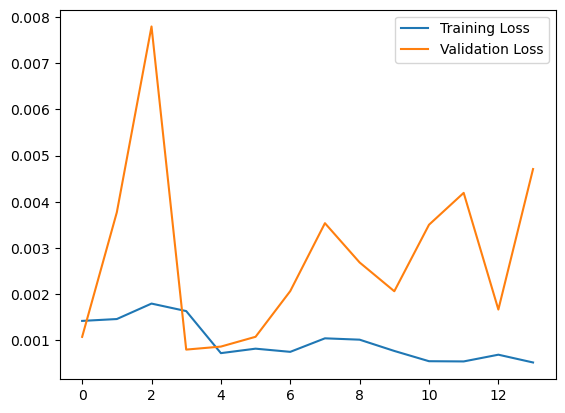

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

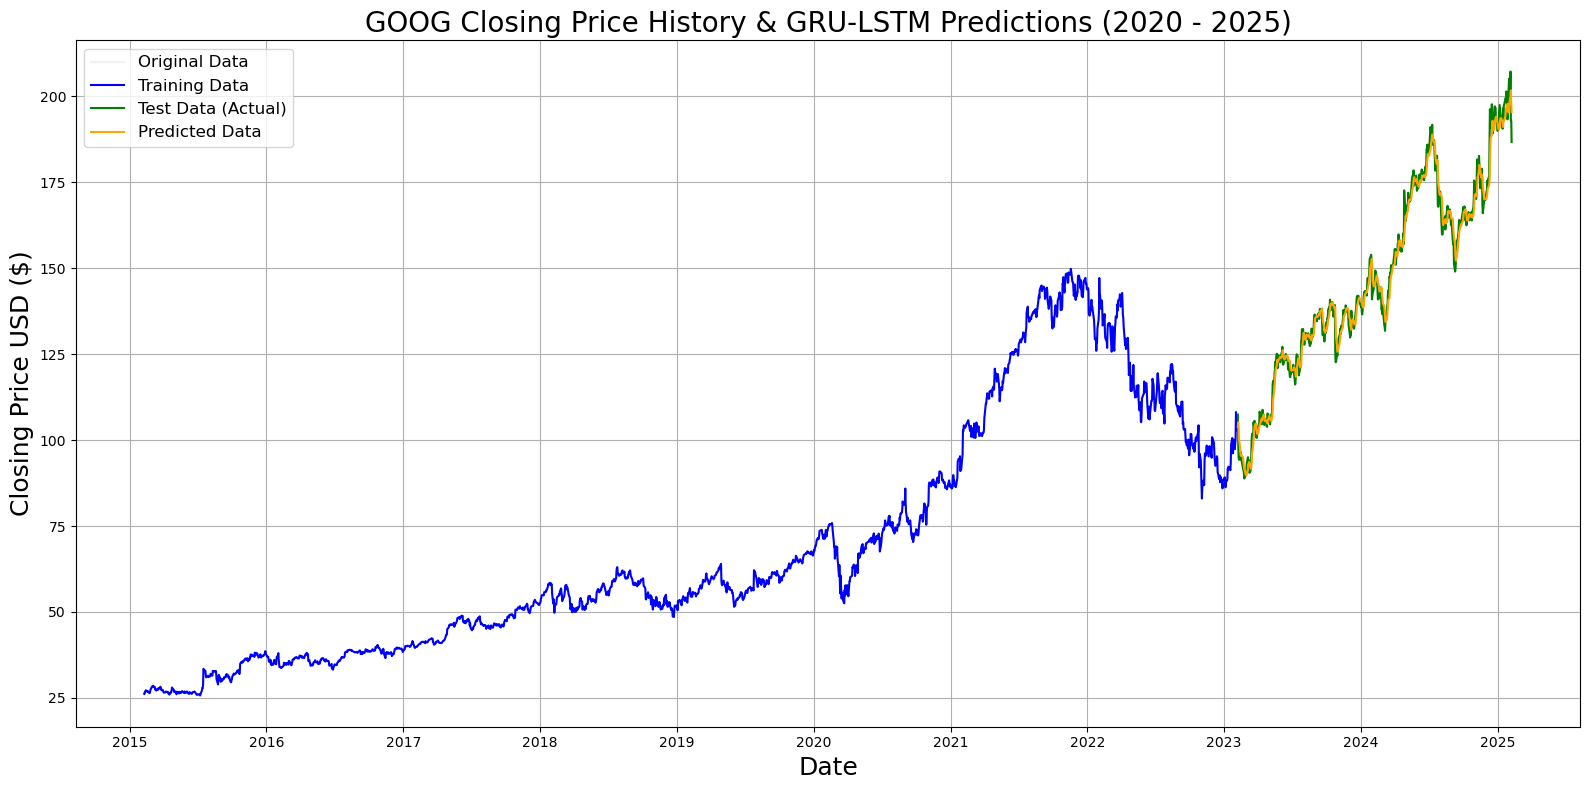

In [55]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('GOOG Closing Price History & GRU-LSTM Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()